## Criação de uma GAN para gerar imagens sintéticas de números manuscritos

Neste estudo irei criar uma Generative Adversarial Network (GAN) básica para tentar criar dados sintéticos de números manuscritos, para isto irei usar a estutura GAN padrão:

```
            +-------------------+
            |   Random Noise z  |   (Entrada do Gerador)
            +-------------------+
                     |
                     v
            +-------------------+
            |     Generator     |   (Gera dados falsos)
            +-------------------+
                     |
                     v
            +-------------------+       +-------------------+
            |  Fake Data (G(z)) | ----> |                   |
            +-------------------+       |                   |
                                        |   Discriminator   | --> Classifica Real/Falso
            +-------------------+       |                   |
            | Real Data (x)     | ----> |                   |
            +-------------------+       +-------------------+
                          ^                       ^
                          |                       |
              (Feedback para Treinamento)    (Feedback para Treinamento)
```

### Carregamento de Bibliotecas

In [1]:
!pip install tensorflow matplotlib numpy > nul 2>&1

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

### Carregar Dataset MNIST e Filtrar as imagens

In [3]:
# define função para carregar um dígito específico no dataset
def load_mnist_digits(digit):
    # carrega o Dataset MNIST
    (x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

    # Filtrar apenas imagens do dígito desejado
    x_train = x_train[y_train == digit]

    # Normalizar para o intervalo [-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5

    # Expandir dimensões para (28, 28, 1), ou seja, 28x28 grayscale
    x_train = np.expand_dims(x_train, axis=-1)

    return x_train

#### Carrega apenas o dígito '2'

In [4]:
dataset = load_mnist_digits(2)
dataset.shape

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


(5958, 28, 28, 1)

### Define o Modelo GAN

#### Cria o Generator (imagens sintéticas a partir de ruídos)
```
Generator Model
-------------------------------------
Input: Random Noise (100,)
     |
Dense Layer (128 neurons, 7x7x128 reshaped)
     |
Conv2DTranspose Layer (128 filters, kernel=4, stride=2, ReLU)
     |
Conv2DTranspose Layer (64 filters, kernel=4, stride=2, ReLU)
     |
Conv2D Layer (1 filter, kernel=7, activation=Tanh)
     |
Output: Synthesized Image (28x28x1)
```

In [5]:
def create_generator():
    model = tf.keras.Sequential([
        layers.Dense(7 * 7 * 128, input_dim=100),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", activation="relu"),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", activation="relu"),
        layers.Conv2D(1, kernel_size=7, activation="tanh", padding="same")  # Saída: 28x28, [-1, 1]
    ])
    return model

#### Cria o Discriminator (tenta distinguir imagens reais das sintéticas)
```
Discriminator Model
-------------------------------------
Input: Image (28x28x1)
     |
Conv2D Layer (64 filters, kernel=4, stride=2, LeakyReLU)
     |
Conv2D Layer (128 filters, kernel=4, stride=2, LeakyReLU)
     |
Flatten Layer
     |
Dense Layer (1 neuron, Sigmoid activation)
     |
Output: Probability (Real or Fake)
```

In [6]:
def create_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=(28, 28, 1)),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")  # Saída: probabilidade
    ])
    return model

#### Cria a GAN

Na prática a GAN é uma Rede Sequencial com o Generator alimentando o Discriminator

In [19]:
def create_gan(generator, discriminator):
    # disciminator não pode ser alterado no modelo (no treinamento ele irá aprender a identificar dados reais)
    # discriminator.trainable = False
    model = tf.keras.Sequential([generator, discriminator])
    return model

In [20]:
generator = create_generator()
discriminator = create_discriminator()

# define o modelo da GAN
gan = create_gan(generator,discriminator)
gan.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ (None, 28, 28, 1)           │       1,030,017 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_7 (Sequential)            │ (None, 1)                   │         138,561 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,168,578 (4.46 MB)

 Trainable params: 1,168,578 (4.46 MB)

 Non-trainable params: 0 (0.00 B)

### Treinamento da GAN

In [21]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.999)

In [22]:
# @tf.function sinaliza ao TensorFlow que esta é uma função a ser otimizada. Ex.: Usar a GPU
@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]

    # Gerar imagens falsas
    random_noise = tf.random.normal([batch_size, 100])
    fake_images = generator(random_noise)

    # Rótulos para real (1) e fake (0)
    real_labels = tf.ones((batch_size, 1))
    fake_labels = tf.zeros((batch_size, 1))

    # Treinar o Discriminador
    with tf.GradientTape() as disc_tape:
        real_predictions = discriminator(real_images)
        fake_predictions = discriminator(fake_images)
        real_loss = loss_fn(real_labels, real_predictions) # todos labels do real_predictions deveriam ser 1, para 100% de acurácia
        fake_loss = loss_fn(fake_labels, fake_predictions) # todos labels do fake_predictions deveriam ser 0, para 100% de acurácia
        disc_loss = real_loss + fake_loss
    # melhora o Discriminator, ensina ele a identificar imagens ((( !!!!!!! )))
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

    # Treinar o Gerador baseado no Discriminator melhorado
    with tf.GradientTape() as gen_tape:
        fake_predictions = discriminator(generator(random_noise))
        # neste ponto, treinamos o gerador de forma oposta ao discriminador, ou seja
        # quando o discriminador classificar uma imagem Fake como Real, iremos reforçar o
        # Gerador de forma positiva.
        gen_loss = loss_fn(real_labels, fake_predictions)  # Queremos que o discriminador aceite as imagens geradas
    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))

    return gen_loss, disc_loss

In [23]:
def train(dataset, epochs, batch_size=64, sample_interval=10):
    # Calcula o número de batches no dataset
    num_batches = original_cardinality / batch_size

    for epoch in range(epochs):
        # Itera sobre os batches usando take(num_batches)
        for batch_index, real_images in enumerate(dataset.take(num_batches)):
            gen_loss, disc_loss = train_step(real_images)

            # Mostra o progresso a cada 10% dos batches
            #if batch_index % (num_batches // 10) == 0:
            #    print(f"Epoch {epoch+1}/{epochs}, Batch {batch_index+1}/{num_batches}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}")

        print(f"Epoch {epoch+1}/{epochs}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}")

        # Salvar imagens geradas
        if epoch % sample_interval == 0:
            generate_and_save_images(epoch)

def generate_and_save_images(epoch, n_samples=16):
    random_noise = tf.random.normal([n_samples, 100])
    fake_images = generator(random_noise)
    fake_images = (fake_images + 1) / 2.0  # Reverter normalização para [0, 1]

    plt.figure(figsize=(4, 4))
    for i in range(n_samples):
        plt.subplot(4, 4, i+1)
        plt.imshow(fake_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.savefig(f'generated_image_epoch_{epoch}.png')
    plt.close()


#### Iniciar o Treinamento da Rede

In [26]:
# Embaralhar o dataset
dataset_tf = tf.data.Dataset.from_tensor_slices(dataset)

# Embaralhar o dataset
original_cardinality = dataset_tf.cardinality().numpy()

dataset_tf = dataset_tf.shuffle(original_cardinality).batch(64)

# Treinar por 100 épocas
train(dataset_tf, epochs=10, sample_interval=10)

Epoch 1/10, Gen Loss: 0.7168847918510437, Disc Loss: 1.3899824619293213
Epoch 2/10, Gen Loss: 0.723505973815918, Disc Loss: 1.37626314163208
Epoch 3/10, Gen Loss: 0.7032522559165955, Disc Loss: 1.3739572763442993
Epoch 4/10, Gen Loss: 0.7121347784996033, Disc Loss: 1.3695752620697021
Epoch 5/10, Gen Loss: 0.6963053345680237, Disc Loss: 1.3845758438110352
Epoch 6/10, Gen Loss: 0.7185802459716797, Disc Loss: 1.380622148513794
Epoch 7/10, Gen Loss: 0.730782151222229, Disc Loss: 1.366746425628662
Epoch 8/10, Gen Loss: 0.7077147364616394, Disc Loss: 1.4024338722229004
Epoch 9/10, Gen Loss: 0.7309221625328064, Disc Loss: 1.361374855041504
Epoch 10/10, Gen Loss: 0.715548574924469, Disc Loss: 1.3650388717651367


## Testando a GAN para criar dígitos

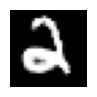

In [34]:
# Gera e mostra um número criado sintéticamente
random_noise = tf.random.normal([1, 100]) # novo vetor de ruído
generated_image = generator(random_noise)
generated_image = (generated_image + 1) / 2.0  # Reverte a normalização

fig, ax = plt.subplots(figsize=(1, 1))

ax.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()